In [1]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
steam_df = pd.read_csv('./data/steam-200k.csv', header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [3]:
steam_df.head(25)

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [4]:
steam_df.value_counts()

UserID     Game                                          Action    Hours  Other
93275329   Grand Theft Auto Vice City                    purchase  1.0    0        2
116876958  Grand Theft Auto III                          purchase  1.0    0        2
27169419   Sid Meier's Civilization IV Beyond the Sword  purchase  1.0    0        2
           Sid Meier's Civilization IV                   purchase  1.0    0        2
46028967   Sid Meier's Civilization IV                   purchase  1.0    0        2
                                                                                  ..
127072755  Mortal Kombat Komplete Edition                purchase  1.0    0        1
                                                         play      0.3    0        1
           Just Cause 2 Multiplayer Mod                  purchase  1.0    0        1
                                                         play      0.7    0        1
5250       Alien Swarm                                   play      4.9

In [5]:
play_data = steam_df[steam_df['Action'] == 'play']

In [6]:
play_data_new = play_data.drop(['Action', 'Other'], axis=1)

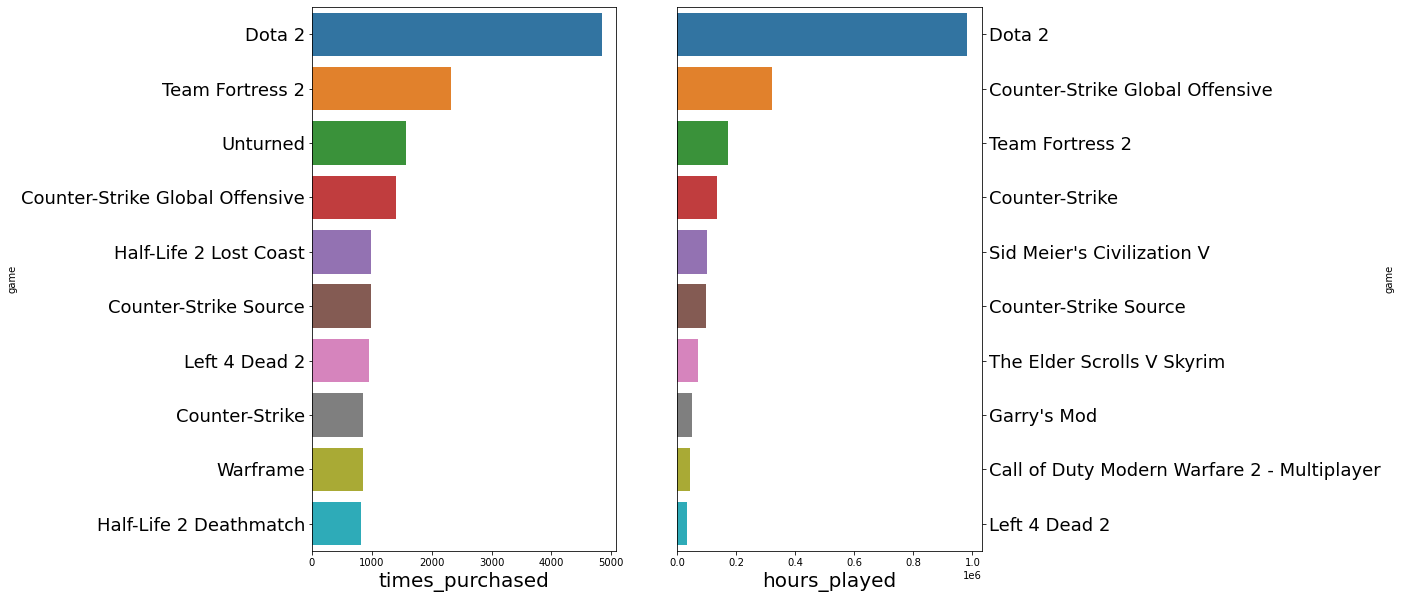

In [7]:
nb_games = 10
df_purchase = steam_df.loc[steam_df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

play_data = steam_df[steam_df['Action'] == 'play']
hours_played = play_data.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

In [8]:
game_hours_min_max = play_data_new.groupby('Game')['Hours'].agg(['min', 'max']).reset_index()

In [9]:
# Define a new function for cumulative hours to fit the rating system
# Recalculate the total hours played for each game across all users
# Create a DataFrame for the rating of each game
game_hours_min_max.columns = ['Game', 'Min_Hours', 'Max_Hours']

# Merge this with the original play_data_new DataFrame
play_data_agg_min_max = play_data_new.merge(game_hours_min_max, on='Game')

play_data_agg_min_max.head()

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0


In [10]:
play_data_agg_min_max.tail(50)

,UserID,Game,Hours,Min_Hours,Max_Hours
70439,154230723,Aces Wild Manic Brawling Action!,0.2,0.2,0.5
70440,231416829,D4 Dark Dreams Don't Die,0.5,0.5,0.5
70441,20772968,BloodRayne,6.6,6.6,6.6
70442,20772968,Carmageddon Max Pack,2.8,2.8,2.8
70443,20772968,Coniclysm,0.3,0.3,0.3
70444,20772968,Alien Shooter Revisited,0.1,0.1,0.1
70445,213854339,Eastside Hockey Manager,1295.0,1295.0,1295.0
70446,213854339,Franchise Hockey Manager 2,11.2,11.2,11.2
70447,47384303,Kohan Immortal Sovereigns,7.9,7.9,7.9
70448,47384303,Avadon 2 The Corruption,2.9,2.9,2.9


In [11]:
filtered_data = play_data_agg_min_max.loc[play_data_agg_min_max['Min_Hours'] != play_data_agg_min_max['Max_Hours']]

In [12]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0
...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5


In [13]:
def ratings_normalize(d):
    new_series = d['Hours'] / d['Max_Hours']
    return new_series

In [14]:
filtered_data['Hours']

0        273.0
1         58.0
2        110.0
3        465.0
4        220.0
         ...  
70424      5.9
70436      1.3
70437      0.8
70438      0.5
70439      0.2
Name: Hours, Length: 69432, dtype: float64

In [15]:
filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)

<ipython-input-15-aef263175d1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)


In [16]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours,Ratings
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0,0.137462
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0,0.029204
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0,0.055388
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0,0.234139
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0,0.110775
...,...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9,1.000000
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3,1.000000
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3,0.615385
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5,1.000000


In [17]:
filtered_data_new = pd.read_csv('./data/filtered_steam_games.csv', index_col=[0])

In [18]:
# baseline

In [19]:
from surprise import Dataset, Reader, NormalPredictor
from surprise.model_selection import cross_validate

# Prepare the data for Surprise
reader = Reader(rating_scale=(filtered_data_new['Ratings'].min(), filtered_data_new['Ratings'].max()))
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# Define the NormalPredictor model
algo = NormalPredictor()

# Perform cross-validation and compute RMSE
results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

# Average RMSE
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using NormalPredictor: {average_rmse}')

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2946  0.2947  0.2992  0.2896  0.2956  0.2947  0.0031  
Fit time          0.02    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.04    0.07    0.03    0.07    0.03    0.05    0.02    
Average RMSE using NormalPredictor: 0.29474710440313706


In [20]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# SVD algo
algo_svd = SVD()

# Perform cross-validation
svd_results = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2158  0.2153  0.2163  0.2181  0.2155  0.2162  0.0010  
MAE (testset)     0.1256  0.1261  0.1264  0.1275  0.1255  0.1262  0.0007  
Fit time          1.36    1.43    1.36    1.31    1.29    1.35    0.05    
Test time         0.08    0.03    0.08    0.03    0.08    0.06    0.02    


In [21]:
from surprise import Reader, Dataset, KNNWithMeans
from surprise.model_selection import cross_validate


# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# Configure KNNWithMeans
algo_knnm = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})

# Perform cross-validation
results_knnm = cross_validate(algo_knnm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2297  0.2267  0.2244  0.2232  0.2288  0.2266  0.0025  
MAE (testset)     0.1399  0.1367  0.1366  0.1344  0.1370  0.1369  0.0018  
Fit time          5.59    5.64    5.50    5.70    5.63    5.61    0.06    
Test time         0.86    0.93    0.88    0.94    0.88    0.90    0.03    


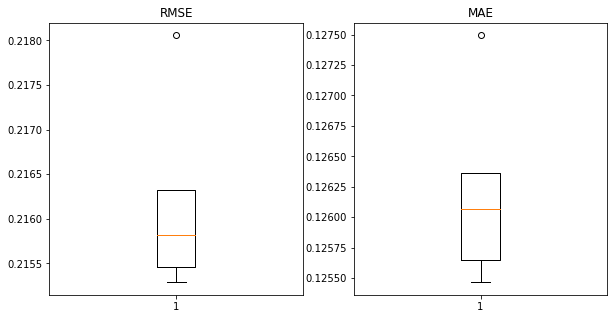

In [22]:
rmse = svd_results['test_rmse']
mae = svd_results['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

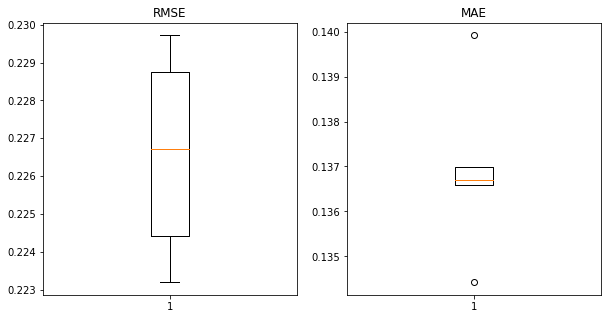

In [23]:
rmse = results_knnm['test_rmse']
mae = results_knnm['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

In [24]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import SVDpp

# Load your dataset
dataset = pd.read_csv('./data/filtered_steam_games.csv')

# Prepare the data for Surprise
reader = Reader(rating_scale=(dataset['Ratings'].min(), dataset['Ratings'].max()))
data = Dataset.load_from_df(dataset[['UserID', 'Game', 'Ratings']], reader)

# Define a range of hyperparameters for GridSearchCV with SVD++
param_grid = {
    'n_factors': [50, 100, 150],  # Number of factors
    'n_epochs': [20, 30],  # Number of epochs
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1]  # Regularization term
}

# Setup GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit the model
gs_svdpp.fit(data)

# Best score and parameters
best_rmse = gs_svdpp.best_score['rmse']
best_params = gs_svdpp.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")


Best RMSE: 0.20895545690772777
Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [25]:
# Need to remove outliers in the 'Hours' column for more sufficient dataset

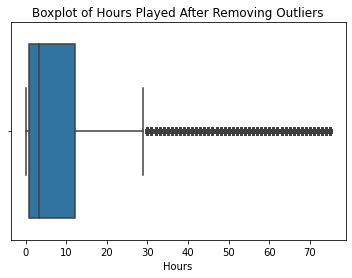

In [18]:
# Calculate IQR for 'Hours'
Q1 = filtered_data_new['Hours'].quantile(0.25)
Q3 = filtered_data_new['Hours'].quantile(0.75)
IQR = Q3 - Q1

# Define an upper bound for outliers
upper_bound = Q3 + 3 * IQR

# Removing outliers from 'Hours'
cleaned_dataset = filtered_data_new[filtered_data_new['Hours'] <= upper_bound]

# New basic statistics  after removing outliers
cleaned_numerical_stats = cleaned_dataset.describe()

# Plotting the new distribution of 'Hours'
plt.figure(figsize=(6, 4))
sns.boxplot(x=cleaned_dataset['Hours'])
plt.title('Boxplot of Hours Played After Removing Outliers')
plt.show()

In [19]:
outliers_removed = filtered_data_new.shape[0] - cleaned_dataset.shape[0]

In [20]:
outliers_removed

7024

In [21]:
filtered_data_new.shape

(69432, 6)

In [22]:
cleaned_dataset.shape

(62408, 6)

In [24]:
# Specify the user ID you're interested in
user_id_of_interest = 142793906  

user_interactions = cleaned_dataset[cleaned_dataset['UserID'] == user_id_of_interest]

games_played = user_interactions['Game'].tolist()  # This will give you a list of games

# Print the games played or interacted with by the user
for game in games_played:
    print(game)

Dota 2
Garry's Mod
Orcs Must Die! 2
Killing Floor
Counter-Strike Global Offensive
DayZ
The Binding of Isaac
Outlast
Risk of Rain
Nosgoth
Awesomenauts
Alan Wake
Rocketbirds Hardboiled Chicken
Contagion
H1Z1
Warframe
Clicker Heroes
Dirty Bomb
Command and Conquer Red Alert 3
The Forest
Sanctum 2
How to Survive
Rise of Incarnates
Hammerwatch
Sakura Clicker
Aura Kingdom
Yet Another Zombie Defense
Wanderlust Rebirth
Deadlight
Fairy Bloom Freesia
Aces Wild Manic Brawling Action!


In [25]:
# Specify the user ID you're interested in
user_id_of_interest = 36714440  # Replace with the actual user ID

# Filter the DataFrame for the user of interest
user_interactions = cleaned_dataset[cleaned_dataset['UserID'] == user_id_of_interest]

# Now user_interactions contains all the rows from the dataframe for the specified user
games_played = user_interactions['Game'].tolist()  # This will give you a list of games

# Print the games played or interacted with by the user
for game in games_played:
    print(game)

Half-Life 2


In [31]:
# cleaned_dataset.to_csv('./data/final_clean_dataset.csv')

In [32]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import SVDpp

# Prepare the data for Surprise
reader = Reader(rating_scale=(cleaned_dataset['Ratings'].min(), cleaned_dataset['Ratings'].max()))
data = Dataset.load_from_df(cleaned_dataset[['UserID', 'Game', 'Ratings']], reader)

# Define a range of hyperparameters
param_grid = {
    'n_factors': [50, 100, 150],  # Number of factors
    'n_epochs': [20, 30],  # Number of epochs
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1],  # Regularization term
    'random_state': [42]    # random_state
}

# GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Fit the model
svdp_model = gs_svdpp.fit(data)

# Best score and parameters
best_rmse = gs_svdpp.best_score['rmse']
best_params = gs_svdpp.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")

Best RMSE: 0.18871512754230896
Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1, 'random_state': 42}


In [33]:
gs_svdpp.cv_results

{'split0_test_rmse': array([0.1923083 , 0.18912912, 0.19011297, 0.18713084, 0.19071595,
        0.18766835, 0.18963877, 0.18672118, 0.19891436, 0.19219826,
        0.1956041 , 0.18897211, 0.19670213, 0.19001676, 0.19430525,
        0.18789295, 0.20383979, 0.1941184 , 0.1990815 , 0.18975823,
        0.20085675, 0.19122059, 0.19668095, 0.18827165]),
 'split1_test_rmse': array([0.19545241, 0.1928319 , 0.19241543, 0.19026632, 0.19337594,
        0.19105041, 0.19155635, 0.18965466, 0.20256946, 0.19579442,
        0.19809691, 0.19194895, 0.1997148 , 0.19324904, 0.19621356,
        0.19070499, 0.20656116, 0.19715865, 0.20137693, 0.19247397,
        0.20331382, 0.19407021, 0.19895897, 0.19088716]),
 'split2_test_rmse': array([0.19697487, 0.19369033, 0.19419873, 0.19104192, 0.19506665,
        0.19185857, 0.19330373, 0.19029854, 0.20087097, 0.19505853,
        0.19738851, 0.1917794 , 0.19857058, 0.19285738, 0.19597286,
        0.190703  , 0.20423151, 0.19562981, 0.19914001, 0.19154681,
        

In [34]:
results_df = pd.DataFrame.from_dict(gs_svdpp.cv_results)

In [35]:
results_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,0.192308,0.195452,0.196975,0.193688,0.194513,0.194587,0.001578,15,0.105569,0.106783,...,39.263744,0.787207,0.389312,0.006952,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.005,0.02,42
1,0.189129,0.192832,0.193690,0.190693,0.191546,0.191578,0.001601,9,0.101647,0.103085,...,38.980893,0.912851,0.392596,0.009771,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.005,0.10,42
2,0.190113,0.192415,0.194199,0.191331,0.191722,0.191956,0.001348,11,0.104219,0.105308,...,38.868095,0.333811,0.396997,0.012295,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.010,0.02,42
3,0.187131,0.190266,0.191042,0.188613,0.189234,0.189257,0.001352,2,0.100951,0.102241,...,38.343339,0.566013,0.393164,0.010235,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.010,0.10,42
4,0.190716,0.193376,0.195067,0.192024,0.192585,0.192753,0.001446,13,0.104323,0.105442,...,57.503071,0.654373,0.388413,0.011622,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.005,0.02,42
5,0.187668,0.191050,0.191859,0.189205,0.189881,0.189933,0.001457,5,0.100735,0.102101,...,57.889717,1.598577,0.387909,0.010539,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.005,0.10,42
6,0.189639,0.191556,0.193304,0.190711,0.190955,0.191233,0.001207,8,0.103257,0.104454,...,57.446207,1.102581,0.382089,0.008602,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.010,0.02,42
7,0.186721,0.189655,0.190299,0.188138,0.188763,0.188715,0.001241,1,0.100613,0.101822,...,58.864782,1.361172,0.392463,0.005287,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.010,0.10,42
8,0.198914,0.202569,0.200871,0.199283,0.200737,0.200475,0.001301,22,0.110763,0.111706,...,68.565518,0.522353,0.392028,0.009082,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.005,0.02,42
9,0.192198,0.195794,0.195059,0.193141,0.194369,0.194112,0.001296,14,0.103649,0.104540,...,67.221440,0.707656,0.386798,0.004654,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.005,0.10,42


In [26]:
from surprise import SVDpp
from surprise import Dataset, Reader

# Load the full dataset from the dataframe
reader = Reader(rating_scale=(cleaned_dataset['Ratings'].min(), cleaned_dataset['Ratings'].max()))
data = Dataset.load_from_df(cleaned_dataset[['UserID', 'Game', 'Ratings']], reader)

# Build the full trainset
full_trainset = data.build_full_trainset()

# Set up the SVD++ algorithm with the given best parameters
algo = SVDpp(n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1, random_state=42)

# Fit the algorithm on the full trainset
algo.fit(full_trainset)

In [27]:
from collections import defaultdict

def get_top_n_recommendations(algo, trainset, n=10):
    # First map the predictions to each user
    top_n = defaultdict(list)
    for inner_uid in trainset.all_users():
        # Retrieve the inner ids of items that the user has already rated
        user_items = set([j for (j, _) in trainset.ur[inner_uid]])
        # Predict ratings for all items the user hasn't rated
        user_ratings = [(trainset.to_raw_iid(inner_iid), algo.predict(trainset.to_raw_uid(inner_uid), trainset.to_raw_iid(inner_iid)).est)
                        for inner_iid in trainset.all_items()
                        if inner_iid not in user_items]
        # Retrieve the top N highest-rated items for this user
        top_n[trainset.to_raw_uid(inner_uid)].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    
    return top_n

# Using the best SVD++ estimator from GridSearchCV results and full trainset
top_n_recommendations = get_top_n_recommendations(algo, full_trainset, n=10)

# Display the recommendations for the first few users for demonstration
for user, user_recommendations in list(top_n_recommendations.items())[:5]:
    print(f"User: {user}")
    for item, rating in user_recommendations:
        print(f"\tI: {item}, Estimated Rating: {rating}")

User: 59945701
	I: Color Symphony, Estimated Rating: 0.5782096129480394
	I: Gladiators Online Death Before Dishonor, Estimated Rating: 0.5695971082595016
	I: Battle Battalions, Estimated Rating: 0.5612957806100842
	I: Let the Cat In, Estimated Rating: 0.5454167538833639
	I: DeathSpank, Estimated Rating: 0.5359164248042716
	I: Layers of Fear, Estimated Rating: 0.5329383559547854
	I: Super House of Dead Ninjas, Estimated Rating: 0.5291551302759325
	I: The Old Tree, Estimated Rating: 0.5287131942402388
	I: Skyborn, Estimated Rating: 0.5251101433985266
	I: Back to the Future Ep 1 - It's About Time, Estimated Rating: 0.5217852454624861
User: 54103616
	I: Battle Battalions, Estimated Rating: 0.6382916872960064
	I: Color Symphony, Estimated Rating: 0.6242452867053326
	I: Gladiators Online Death Before Dishonor, Estimated Rating: 0.6146296322906977
	I: Back to the Future Ep 1 - It's About Time, Estimated Rating: 0.6090440903112027
	I: Aeon Command, Estimated Rating: 0.6031602791859512
	I: Deat

In [38]:
import random
from collections import defaultdict

def get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=3):
    """Generate top-n recommendations for a random sample of users."""
    top_n = defaultdict(list)
    
    # Get a random sample of users from the trainset
    all_users = list(full_trainset.all_users())
    random_users = random.sample(all_users, num_users)
    
    for inner_uid in random_users:
        # Retrieve the inner ids of items that the user has already rated
        user_items = set([j for (j, _) in full_trainset.ur[inner_uid]])
        # Predict ratings for all items the user hasn't rated
        user_ratings = [(full_trainset.to_raw_iid(inner_iid), algo.predict(full_trainset.to_raw_uid(inner_uid), full_trainset.to_raw_iid(inner_iid)).est)
                        for inner_iid in full_trainset.all_items()
                        if inner_iid not in user_items]
        # Retrieve the top N highest-rated items for this user
        top_n[full_trainset.to_raw_uid(inner_uid)].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    
    return top_n

# Generate recommendations for a random sample of users
num_random_users = 3 
random_user_recommendations = get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=num_random_users)

# Display the recommendations for the sampled users
for user, user_recommendations in random_user_recommendations.items():
    print(f"User: {user}")
    for item, rating in user_recommendations:
        print(f"\tGame: {item}, Estimated Rating: {rating}")

User: 302813048
	Game: Color Symphony, Estimated Rating: 0.6788960252349374
	Game: Battle Battalions, Estimated Rating: 0.6390320845347744
	Game: Dr. Langeskov, The Tiger, and The Terribly Cursed Emerald A Whirlwind Heist, Estimated Rating: 0.6022103120556972
	Game: Tales of Monkey Island Chapter 5 - Rise of the Pirate God, Estimated Rating: 0.5959886017597258
	Game: Back to the Future Ep 3 - Citizen Brown, Estimated Rating: 0.584379049653819
	Game: Carpe Diem, Estimated Rating: 0.5631320025654218
	Game: Arma 2 British Armed Forces, Estimated Rating: 0.556516685739953
	Game: Unreal II The Awakening, Estimated Rating: 0.5546027875974762
	Game: FarSky, Estimated Rating: 0.5489459669461388
	Game: StarDrive 2, Estimated Rating: 0.5422081348616972
User: 170095814
	Game: Battle Battalions, Estimated Rating: 0.6726100676579735
	Game: Gladiators Online Death Before Dishonor, Estimated Rating: 0.6335195250543023
	Game: Layers of Fear, Estimated Rating: 0.6333774365707054
	Game: Color Symphony, 

In [39]:
import random
from collections import defaultdict

def get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=5):
    """Generate top-n recommendations for a random sample of users."""
    top_n = defaultdict(list)
    
    # Get a random sample of users from the trainset
    all_users = list(full_trainset.all_users())
    random_users = random.sample(all_users, num_users)
    
    for inner_uid in random_users:
        # Retrieve the inner ids of items that the user has already rated
        user_items = set([j for (j, _) in full_trainset.ur[inner_uid]])
        # Predict ratings for all items the user hasn't rated
        user_ratings = [(full_trainset.to_raw_iid(inner_iid), algo.predict(full_trainset.to_raw_uid(inner_uid), full_trainset.to_raw_iid(inner_iid)).est)
                        for inner_iid in full_trainset.all_items()
                        if inner_iid not in user_items]
        # Retrieve the top N highest-rated items for this user
        top_n[full_trainset.to_raw_uid(inner_uid)].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    
    return top_n

# Generate recommendations for a random sample of users
num_random_users = 5 
random_user_recommendations = get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=num_random_users)

# Display the recommendations for the sampled users
for user, user_recommendations in random_user_recommendations.items():
    print(f"User: {user}")
    for item, rating in user_recommendations:
        print(f"\tGame: {item}, Estimated Rating: {rating}")

User: 123875734
	Game: Battle Battalions, Estimated Rating: 0.8530357431041231
	Game: Color Symphony, Estimated Rating: 0.8155450424212449
	Game: Back to the Future Ep 1 - It's About Time, Estimated Rating: 0.7412520683530869
	Game: Gladiators Online Death Before Dishonor, Estimated Rating: 0.733360890640888
	Game: Painkiller Redemption, Estimated Rating: 0.7001914539581939
	Game: The Old Tree, Estimated Rating: 0.6973980076236531
	Game: Let the Cat In, Estimated Rating: 0.6967341102643777
	Game: Back to the Future Ep 3 - Citizen Brown, Estimated Rating: 0.6952084361250493
	Game: Pirates of Black Cove, Estimated Rating: 0.6949515278101089
	Game: Superfrog HD, Estimated Rating: 0.6874480948894006
User: 15702351
	Game: Bob Came in Pieces, Estimated Rating: 0.5982682690349224
	Game: Teslagrad, Estimated Rating: 0.5894144477694954
	Game: Holy Potatoes! A Weapon Shop?!, Estimated Rating: 0.5808195764537385
	Game: Color Symphony, Estimated Rating: 0.578918088299763
	Game: Plug & Play, Estima

In [32]:
df = pd.read_csv('./data/final_clean_dataset.csv')

In [33]:
from collections import defaultdict


def get_recommendations(user_id, n=5):
    # Convert the user_id input from string to integer
    user_id = int(user_id)
    # Get inner user id from the raw user id
    inner_user_id = full_trainset.to_inner_uid(user_id)
    # Now we can get recommendations for the specific user
    user_recommendations = defaultdict(list)
    user_items = set([j for (j, _) in full_trainset.ur[inner_user_id]])
    user_ratings = [(full_trainset.to_raw_iid(inner_iid), algo.predict(user_id, full_trainset.to_raw_iid(inner_iid)).est)
                    for inner_iid in full_trainset.all_items()
                    if inner_iid not in user_items]
    user_recommendations[user_id].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    return user_recommendations[user_id]



In [34]:
def get_user_games(user_id, df):
    
    user_games = df[df['UserID'] == int(user_id)]['Game'].tolist()
    return user_games


In [40]:
import gradio as gr

def recommend_and_show_played_games(user_id):
    try:
        # Get the list of games the user has already played
        played_games = get_user_games(user_id, df)
        # Get recommendations for the user
        recommendations = get_recommendations(user_id)
        
        # Format the played games and recommendations into strings
        played_games_str = "Games Played:\n" + "\n".join(played_games)
        recommendations_str = "\nRecommended Games:\n" + "\n".join([f"{game}: {rating:.2f}" for game, rating in recommendations])
        
        # Return both strings
        return played_games_str + "\n\n" + recommendations_str
    except Exception as e:
        return str(e)


interface = gr.Interface(
    fn=recommend_and_show_played_games,
    inputs="text",
    outputs="text",
    examples=[["Enter User ID here"]]
)

interface.launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [ ]:
# Function for error handling Gradio
def recommend_games(user_id):
    try:
        # Convert user_id to the expected type, e.g., integer
        user_id = int(user_id)
        
        recommendations = get_recommendations(user_id)
        
        # Format the recommendations into a string or a list to return through Gradio
        return '\n'.join([f"{game}: {rating:.2f}" for game, rating in recommendations])
    except ValueError:
        return "Invalid user ID format. Please enter a numeric user ID."
    except KeyError:
        return "User ID not found in the dataset."
    except Exception as e:
        # Generic error handling for any other unexpected errors
        return str(e)